In [1]:
# подгружаем все нужные пакеты
import pandas as pd
import numpy as np

# import pandas_profiling as pp

import os
import sys
import math
import string
import itertools as it
from transliterate import translit

from collections import defaultdict

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, classification_report, precision_score, recall_score, roc_curve
from sklearn.model_selection import train_test_split

# для встроенных картинок
%pylab inline
# чуть покрасивше картинки:
pd.set_option('display.mpl_style', 'default')
figsize(12, 9)

import warnings
warnings.filterwarnings("ignore")

#plt.rcParams['figure.figsize'] = 10, 7.5
#plt.rcParams['axes.grid'] = True
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
# import seaborn as sns


import matplotlib as mpl
mpl.rcParams['font.family'] = 'Verdana' # Ubuntu

plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rc('font', weight='bold')
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)

# чтобы был русский шрифт
from matplotlib import rc
 
font = {'family': 'Verdana', #Droid Sans
        'weight': 'normal'}
rc('font', **font)
import pickle as pkl

Populating the interactive namespace from numpy and matplotlib


/home/ubuntu/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2881: FutureWarning: 
mpl_style had been deprecated and will be removed in a future version.
Use `matplotlib.pyplot.style.use` instead.

  exec(code_obj, self.user_global_ns, self.user_ns)


In [97]:
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
pd.options.display.max_colwidth = 100

In [3]:
import gzip

## Reading

In [4]:
df_orders_drivers = pd.read_csv('./orders_drivers.csv', parse_dates=True)

In [5]:
df_orders_drivers['order_datetime'] = pd.to_datetime(df_orders_drivers['order_datetime'])

In [6]:
# parsim dati | dni nedeli | 4asi
df_orders_drivers['week'] = df_orders_drivers['order_datetime'].dt.week
df_orders_drivers['day'] = df_orders_drivers['order_datetime'].dt.day
df_orders_drivers['hour'] = df_orders_drivers['order_datetime'].dt.hour
df_orders_drivers['weekday'] = df_orders_drivers['order_datetime'].dt.weekday

In [9]:
df_orders_drivers.head(3)

,order_gk,order_datetime,driver_gk,order_status,class_type,rider_total_cost,paid_with_prepaid,payment_type,ride_type,m_ride_duration,ride_distance_key,m_driver_wait_time,m_rating,rider_ftp_date_key,rider_main_device_desc,driver_ftp_date_key,driver_device_platform,total_loyalty_points,acquisition_channel_desc,week,day,hour,weekday
0,173965,2017-09-25 18:36:01,1137,Completed,Standard,586.00,NaN,Voucher,business,1281.0,5.8,7.0,NaN,2012-10-05,unknown,2016-12-01,Android,105,COMPANY,39,25,18,0
1,782457,2017-09-15 09:14:38,1137,Completed,Economy,542.37,NaN,Voucher,business,2000.0,16.5,120.0,4.0,2017-04-28,iOS,2016-12-01,Android,4855,MOBILE,37,15,9,4
2,647029,2017-09-25 16:15:15,1137,Completed,Standard,435.59,NaN,Voucher,business,1171.0,9.1,362.0,NaN,2017-04-11,iPhone,2016-12-01,Android,2285,COMPANY,39,25,16,0


In [10]:
# outlier exclusion
df_orders_drivers = df_orders_drivers[df_orders_drivers.driver_gk != 2561]

In [11]:
# make distibution of order probability in different hours for loyal drivers 
top100_drivers = df_orders_drivers.groupby('driver_gk').size().nlargest(100)

In [12]:
top100_drivers= list(top100_drivers.index)

In [13]:
%matplotlib inline

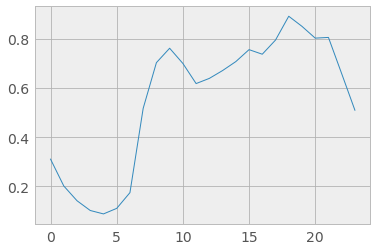

In [14]:
# how this distribution looks like
plt.plot(df_orders_drivers[df_orders_drivers.driver_gk.isin(top100_drivers)].groupby('hour').size()/(100*28))

In [15]:
# save probabilities to list
proba_fs = list(df_orders_drivers[df_orders_drivers.driver_gk.isin(top100_drivers)].groupby('hour').size()/(100*28))

In [16]:
# lets calculate expected alue and real value (number of orders) by day
df_chorn = df_orders_drivers.groupby(by = ['driver_gk', 'day']).agg({'hour':['min', 'max','count']}).reset_index()    

In [17]:
#reset multiindex
df_chorn.columns = df_chorn.columns.get_level_values(0)

In [18]:
df_chorn.columns = ['driver_gk','day','hour_min','hour_max','hour_count']

In [19]:
proba_fs[0:2]

[0.31071428571428572, 0.20178571428571429]

In [20]:
def predicted_cnt(h_min, h_max):
    return np.asarray(proba_fs[h_min:h_max+1]).sum()

In [21]:
#calculate expected value during workday
df_chorn['pred_ord'] = df_chorn.apply(lambda x: predicted_cnt(x.hour_min, x.hour_max), axis = 1)

In [22]:
#add real weeks (not calendar)
df_chorn['r_week'] = 1
df_chorn['r_week'][df_chorn.day.isin([1,2,3,4,5,6,7])] = 1
df_chorn['r_week'][df_chorn.day.isin([8,9,10,11,12,13,14])] = 2
df_chorn['r_week'][df_chorn.day.isin([15,16,17,18,19,20,21])] = 3
df_chorn['r_week'][df_chorn.day.isin([22,23,24,25,26,27,28])] = 4

In [23]:
#aggregate be these weeks
df_chorn_1 = df_chorn.groupby(by = ['driver_gk','r_week']).agg({'hour_count':'mean', 'pred_ord':'mean'}).reset_index()

In [26]:
df_chorn_1[df_chorn_1.pred_ord == 0]

,driver_gk,r_week,pred_ord,hour_count


In [29]:
#calculate gett share
def compute_share(df_chorn_1):
    return df_chorn_1.hour_count / df_chorn_1.pred_ord
df_chorn_1['gett_share'] = df_chorn_1.apply(lambda x: compute_share(x), axis = 1)

In [33]:
df_chorn_1[df_chorn_1.gett_share > 1]

,driver_gk,r_week,pred_ord,hour_count,gett_share
4,1,1,12.123357,14.600000,1.204287
5,1,2,11.442653,16.571429,1.448216
6,1,3,9.143316,13.714286,1.499925
7,1,4,10.784694,13.571429,1.258397
23,6,1,8.628869,8.833333,1.023695
24,6,2,4.960153,5.857143,1.180839
25,6,3,7.840357,9.000000,1.147907
35,9,1,1.894196,2.250000,1.187839
43,11,1,4.569286,5.000000,1.094263
44,11,2,4.294940,5.000000,1.164160


In [41]:
#flatten by weeks for fit/predict
df1 = df_chorn_1.pivot(index = 'driver_gk', columns = 'r_week', values ='gett_share').reset_index()

In [43]:
df1.columns = ['driver_gk', 'week1','week2','week3','week4']

In [48]:
#take only active drivers
df1 = df1[df1.week1.notnull()][df1.week2.notnull()][df1.week3.notnull()][df1.week4.notnull()]

In [88]:
df1.to_excel('df1.xlsx')

In [86]:
df1.head()

,driver_gk,week1,week2,week3,week4,week4_forecast,week4_f_coef,head_segm
0,0,0.585661,0.691340,0.638852,0.654206,0.691808,0.026595,0.00
1,1,1.204287,1.448216,1.499925,1.258397,1.679780,0.147819,0.10
2,2,0.847701,0.801496,0.510902,0.507086,0.383234,-0.168400,-0.10
4,4,0.523901,0.418017,0.803489,0.418163,0.861391,0.139794,0.10
5,5,0.945832,0.603831,0.755291,0.632340,0.577778,-0.095270,-0.05


In [71]:
# easy forecastshare by linear mocdels
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
import matplotlib.pyplot as plt

lr = linear_model.LinearRegression()

def forecast(x):
    lr.fit([[1],[2],[3]], [x.week1,x.week2,x.week3])
    return lr.predict(4)[0]
df1['week4_forecast'] = df1.apply(lambda x: forecast(x), axis = 1)

In [95]:
df1.columns

Index([u'driver_gk', u'week1', u'week2', u'week3', u'week4', u'week4_forecast',
       u'week4_f_coef', u'head_segm'],
      dtype='object')

In [79]:
# just additionally extract coeficients of linear model
def forecast_tr(x):
    lr.fit([[1],[2],[3]], [x.week1,x.week2,x.week3])
    return lr.coef_[0]
df1['week4_f_coef'] = df1.apply(lambda x: forecast_tr(x), axis = 1)

In [85]:
# add some spec segmentation and then extract to excel to look
df1['head_segm'] = -0.2
df1['head_segm'][df1.week4_f_coef > -0.2] = -0.1
df1['head_segm'][df1.week4_f_coef > -0.1] = -0.05
df1['head_segm'][df1.week4_f_coef > -0.05] = 0
df1['head_segm'][df1.week4_f_coef > 0.05] = 0.05
df1['head_segm'][df1.week4_f_coef > 0.1] = 0.1
df1['head_segm'][df1.week4_f_coef > 0.2] = 0.2

In [87]:
df1.groupby('head_segm').size()

head_segm
-0.20     721
-0.10     835
-0.05     683
 0.00    1666
 0.05     716
 0.10     834
 0.20     628
dtype: int64

In [92]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))